Gender : Female, conf = 0.748
Age Output : [[2.0428606e-05 8.9470815e-04 8.9217430e-01 1.5337433e-02 5.4884281e-02
  8.1858836e-04 3.5504568e-02 3.6566370e-04]]
Age : (8-12), conf = 0.892


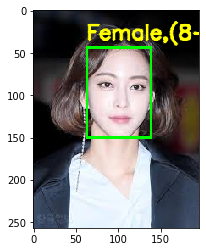

In [15]:
import cv2
import math
import time
import matplotlib.pyplot as plt



def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()
    
    

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes


faceProto = "cfg_file/agegender/opencv_face_detector.pbtxt"
faceModel = "cfg_file/agegender/opencv_face_detector_uint8.pb"

ageProto = "cfg_file/agegender/age_deploy.prototxt"
ageModel = "cfg_file/agegender/age_net.caffemodel"

genderProto = "cfg_file/agegender/gender_deploy.prototxt"
genderModel = "cfg_file/agegender/gender_net.caffemodel"

#MODEL_MEAN_VALUES = 
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)

frame = cv2.imread("pic/han3.jpg")
frameFace, bboxes = getFaceBox(faceNet, frame) # 얼굴을 찾는 함수
padding = 10
for bbox in bboxes:
        #얼굴 자르는 부분, padding 은 범위를 조금 넓혀주면서 얼굴부분이 잘릴수있는 문제를 완화시켜줌
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]
        
        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746), swapRB=False) #평균값?
        genderNet.setInput(blob) #잘라진 얼굴이 남자인지 여자인지 판별
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob) #잘라진 얼굴의 나이 판별
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)        
        #cv2.imwrite("age-gender-out-{}".format(args.input),frameFace)
        cv2.imwrite('output.jpg',frameFace)
        
imshow('',frameFace)